# Assignment 4
### Do three of four.

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [65]:
minnesota=pd.read_csv("mn_police_use_of_force.csv")

In [66]:
minnesota.head()

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West


In [67]:
minnesota['injury_na'] = minnesota['subject_injury'].isna()

In [68]:
minnesota['injury_na'].value_counts()

injury_na
True     9848
False    3077
Name: count, dtype: int64

In [69]:
pd.crosstab(minnesota['injury_na'], minnesota['race'], normalize='columns')

race,Asian,Black,Native American,Other / Mixed Race,Pacific Islander,White
injury_na,,,,,,
False,0.364341,0.240847,0.280612,0.590244,0.0,0.246405
True,0.635659,0.759153,0.719388,0.409756,1.0,0.753595


In [70]:
def stat(x):
    stat = np.mean(x)
    return stat

In [71]:
def stat_by_group_mean(df, var_name, group_name):

    return df.groupby(group_name)[var_name].mean()

In [72]:
def simulate_stratified(df, var_name, group_name, S=2500, plot=True):
    """Performs a stratified bootstrap and optionally plots KDEs for each group."""
    estimates = []

    # Compute original group means
    original_stats = stat_by_group_mean(df, var_name, group_name)

    # Stratified bootstrap
    for s in range(S):
        df_s = df.groupby(group_name, group_keys=False).sample(frac=1.0, replace=True)
        stats_s = stat_by_group_mean(df_s, var_name, group_name)
        estimates.append(stats_s)

    estimates_df = pd.concat(estimates, axis=1).T

    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        for col in estimates_df.columns:
            sns.kdeplot(estimates_df[col], label=col, fill=True, alpha=0.3)
        plt.title(f"KDEs of bootstrap means for {var_name} stratified by {group_name}")
        plt.legend(title=group_name)
        plt.show()

    return original_stats, estimates_df


/var/folders/09/89r30_ms6xdcd7znk61plqgr0000gn/T/ipykernel_2906/1249646364.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(estimates_df[col], label=col, fill=True, alpha=0.3)


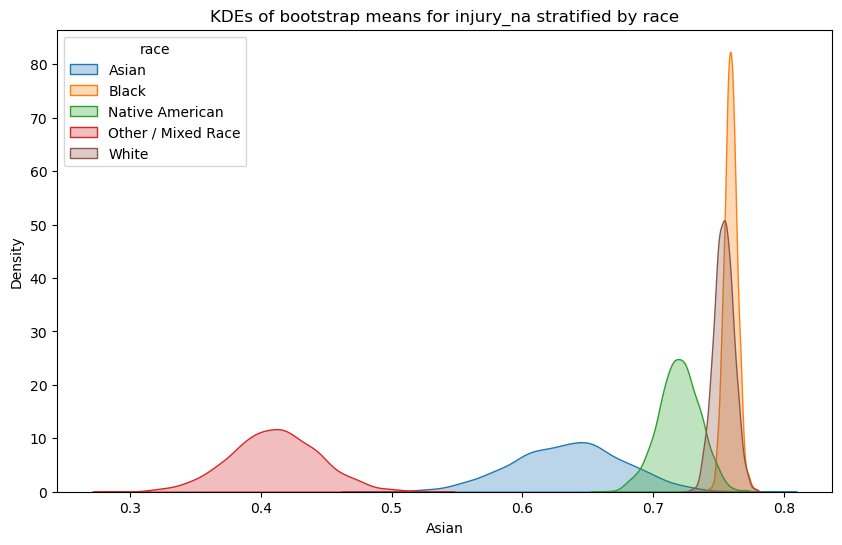

In [73]:
original_stats, estimates_df = simulate_stratified(
    df=minnesota,
    var_name="injury_na",
    group_name="race",
    S=2500,       # number of bootstrap samples (optional, default=2500)
    plot=True     # whether to plot the KDEs
)


### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

The statistic I computed was the mean, and the variable I focused on was 'vsa_grad_after6_transfer'. 

In [74]:
college=pd.read_csv("college_completion.csv")

In [75]:
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # This iterates through instances in the data frame 1000 times and draws a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        #This line computes the statistic of interest on the new sample
        stat_s = fcn(x_s)
        # This appends the statistic of interest to the list
        estimates.append(stat_s)
    estimates = np.array(estimates) # This converts estimates list to numpy array

    # This following section is plotting a KDE plot for the estimates and the original data.
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

In [76]:
def stat(x):
    stat = np.mean(x)
    return stat

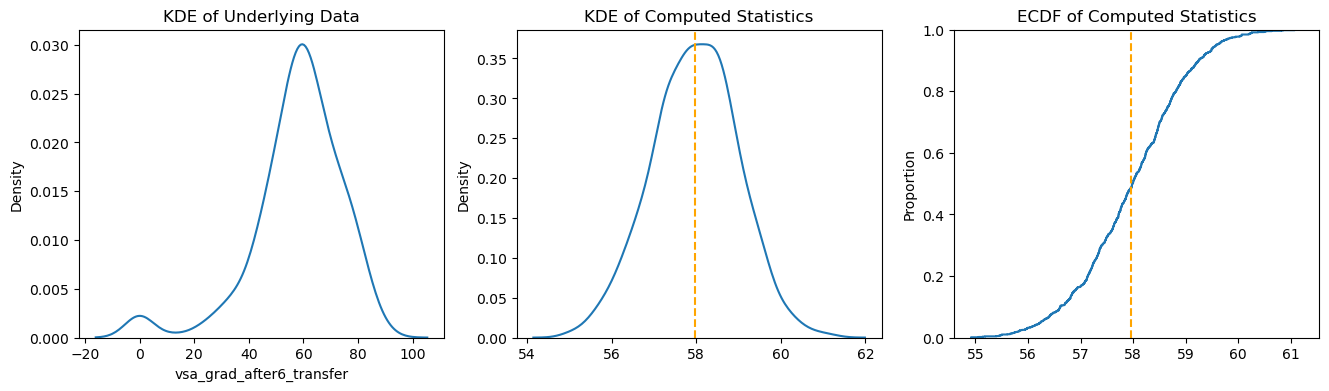

Variance of estimates is: 1.036581379583382


In [77]:
var = 'vsa_grad_after6_transfer'
estimates = simulate(var, college, stat)

In [78]:
def interval (L,H, estimates):
    """Computes the (L,H) percentile interval from the bootstrap estimates."""
    lower = np.percentile(estimates, L)
    upper = np.percentile(estimates, H)
    return lower, upper

In [79]:
print("lower bound, upper bound=",interval(5,95,estimates))

lower bound, upper bound= (np.float64(56.24578016039051), np.float64(59.57658045977012))


### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

The goal of the trial is to figure out the best management strategy for patients with SIHD, or moderate and advanced kidney disease. 

More specifically, the trial is supposed to determine whether an invasive method of cardiaatic cath will reduce the likelihood that patients with SIHD and advanced CKD will die over 2.8, when compared to the control group. 

In [80]:
n_con= 389
y_con=np.ones(n_con)
y_con[:129]=0
df_con=pd.DataFrame({"arm":"conservative", "outcome": y_con})

n_inv=388
y_inv=np.ones(n_inv)
y_inv[:123]=0
df_inv=pd.DataFrame({"arm":"invasive", "outcome": y_inv})


In [81]:
est_con=[]
est_inv=[]
est_diff=[]

for s in range(2000):
    df_s = pd.concat([df_con.sample(frac=1.0, replace=True), df_inv.sample(frac=1.0, replace=True)])
    est_con.append(np.mean(df_s[df_s['arm']=='conservative']['outcome']))
    est_inv.append(np.mean(df_s[df_s['arm']=='invasive']['outcome']))
    est_diff.append(est_con[-1]-est_inv[-1])

In [82]:
obs_con = df_con['outcome'].mean()
obs_inv = df_inv['outcome'].mean()
obs_diff = obs_con - obs_inv


In [83]:
ci_lower, ci_upper = np.percentile(est_diff, [2.5, 97.5])

The histogram suggests that conservative strategy's rate of negative outcome is around 1 percentage points lower than the invasive strategy. The confidence intervals suggest that we are 95% confident that the true difference between the conservative strategy's rate of negative outcome and the invasive strategy's rate of negative outcome is no less than -8 percentage points and no greater than 5 percentage points.  

It's important to note that the observed difference of -1 percentage points is not statistically significant because the 95% confidence interval includes zero. This means that we cannot be confident that there is a difference in mean rate of negative outcomes between the conservative strategy and the invasive strategy.

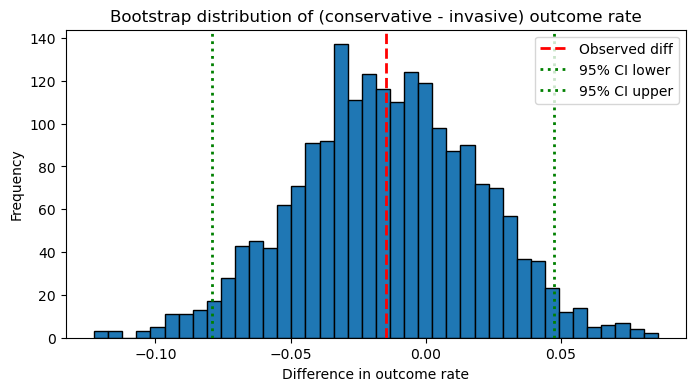

In [84]:
plt.figure(figsize=(8,4))
plt.hist(est_diff, bins=40, edgecolor="black")
plt.axvline(obs_diff, color="red", linewidth=2, linestyle="--", label="Observed diff")
plt.axvline(ci_lower, color="green", linestyle=":", linewidth=2, label="95% CI lower")
plt.axvline(ci_upper, color="green", linestyle=":", linewidth=2, label="95% CI upper")
plt.title("Bootstrap distribution of (conservative - invasive) outcome rate")
plt.xlabel("Difference in outcome rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

In [ ]:
import numpy as np
from scipy.stats import norm


def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)


def calculate_bandwidth(X):
    n = len(X)
    std_x = np.std(X, ddof=1)
    h = 1.06 * std_x * (n**(-1/5))
    return h


def lcls_estimator(z_grid, X, Y, h):
    y_hat = np.zeros_like(z_grid, dtype=float)
    for j, z in enumerate(z_grid):
        u = (z - X) / h

        K = (1/h) * epanechnikov_kernel(u)

        numerator = np.sum(Y * K)

        denominator = np.sum(K)

        if denominator > 1e-9: 
            y_hat[j] = numerator / denominator
        else:
            y_hat[j] = np.nan 

    return y_hat

In [87]:
N_bootstrap = 30
X=college["cohort_size"].values
Y=college["vsa_grad_after6_transfer"].values
Z_grid = np.linspace(np.min(X), np.max(X), 100) 
h = calculate_bandwidth(X) 

for _ in range(N_bootstrap):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    X_boot, Y_boot = X[idx], Y[idx]
    y_boot_pred = lcls_estimator(Z_grid, X_boot, Y_boot, h)





In [89]:

valid_indices = np.isfinite(X) & np.isfinite(Y)

X_clean = X[valid_indices]
Y_clean = Y[valid_indices]


z_targets = np.percentile(X_clean, [25, 50, 75])


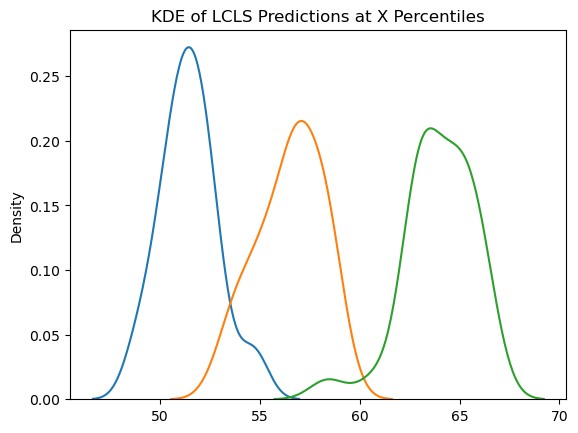

In [ ]:
N_pred_bootstrap = 30
h = calculate_bandwidth(X_clean) # Use clean X for bandwidth
prediction_distributions = {z: [] for z in z_targets}

for _ in range(N_pred_bootstrap):

    idx = np.random.choice(len(X_clean), size=len(X_clean), replace=True)
    

    X_boot, Y_boot = X_clean[idx], Y_clean[idx] 
    

    for z in z_targets:
        y_pred = lcls_estimator([z], X_boot, Y_boot, h)[0]
        prediction_distributions[z].append(y_pred)

for z, preds in prediction_distributions.items():
    sns.kdeplot(preds, label=f'z = {z:.2f}')
    plt.title('KDE of LCLS Predictions at X Percentiles')

The most variable, and least variable prediction is likely the blue line. This is because the shape of the graph is the most narrow and is the tallest. This suggests that the LCLS prediction at this z- value has the lowest variance. 

The next most reliable prediction is likely the orange line since the distribution is wider than the blue line but narrower than the green line, and thus more consistent. 

Finally the least reliable prediction is the green line because the distribution is the widest and the shortest, suggesting that the LCLS prediction at this z-value has high variance.

